## **CIFAR10 image classification**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### **1. Load the dataset/Preprocess the data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

def data_preprocessing(x, y):
  x = np.array(x, dtype=np.float32)
  y = np.array(y, dtype=np.float32)
  return x, y

def data_one_hot_encoding(x, y):
  x, y = data_preprocessing(x, y)
  y_ohe = to_categorical(y)
  return x, y_ohe

def get_train_valid_test_data(train_x, train_y, test_x, test_y, valid_size=0.2, random_state=42):
  train_x, train_y_ohe = data_one_hot_encoding(train_x, train_y)
  test_x, test_y_ohe = data_one_hot_encoding(test_x, test_y)
  train_x, valid_x, train_y_ohe, valid_y_ohe = train_test_split(train_x, train_y_ohe, test_size=valid_size, random_state=random_state)
  return (train_x, train_y_ohe), (valid_x, valid_y_ohe), (test_x, test_y_ohe)

set_random_seed(42)

(train_x, train_y), (test_x, test_y) = cifar10.load_data()
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(tr_x, tr_y_ohe), (val_x, val_y_ohe), (ts_x, ts_y_ohe) = \
get_train_valid_test_data(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42)
print(tr_x.shape, tr_y_ohe.shape, val_x.shape, val_y_ohe.shape, ts_x.shape, ts_y_ohe.shape)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


### **2. Visualize the data**

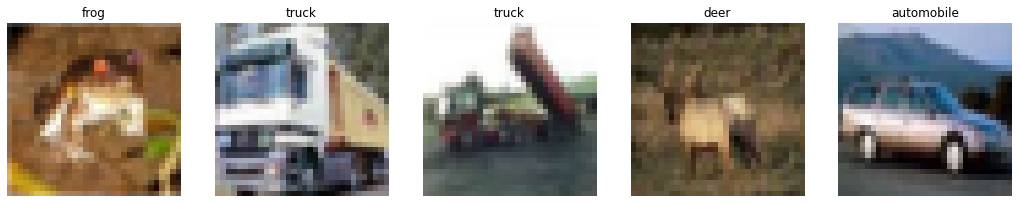

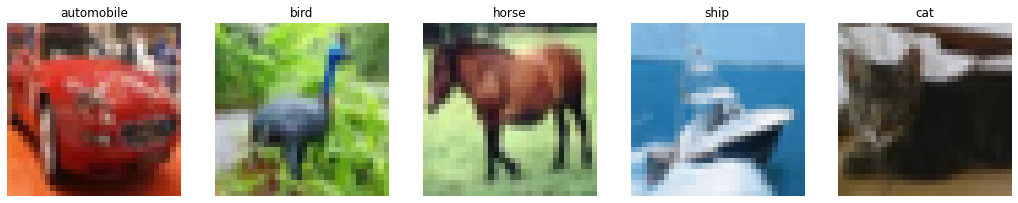

In [ ]:
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(x, y, ncols=5):
  fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=ncols)
  for i in range(ncols):
    axs[i].axis('off')
    axs[i].imshow(x[i])
    y_label = y[i].squeeze()
    axs[i].set_title(f'{class_names[int(y_label)]}', fontsize=12)

show_images(train_x[:5], train_y[:5], ncols=5)
show_images(train_x[5:10], train_y[5:10], ncols=5)

### **3. Data augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

b_size = 32

train_generator = ImageDataGenerator(horizontal_flip=True, rescale=1/255.0)
valid_generator = ImageDataGenerator(rescale=1/255.0)
test_generator = ImageDataGenerator(rescale=1/255.0)

train_generator_flow = train_generator.flow(tr_x, tr_y_ohe, batch_size=b_size, shuffle=True)
valid_generator_flow = valid_generator.flow(val_x, val_y_ohe, batch_size=b_size, shuffle=True)
test_generator_flow = test_generator.flow(ts_x, ts_y_ohe, batch_size=b_size, shuffle=False)

### **4. Build the model**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D

x_size = 32

def create_model():
  input_tensor = Input(shape=(x_size, x_size, 3))
  x = Conv2D(filters=64, kernel_size=3, padding='same')(input_tensor)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(2)(x)

  x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(2)(x)

  x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(300, activation='relu')(x)
  x = Dropout(0.3)(x)
  output = Dense(10, activation='softmax')(x)
        
  model = Model(inputs=input_tensor, outputs=output)
  return model

In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

### **5. Compile/Train the model**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cb_rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', patienc=10, factor=0.2, verbose=1)
cb_esp = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)

In [ ]:
x_batch, y_batch = next(train_generator_flow)
x_batch.shape, y_batch.shape

((32, 32, 32, 3), (32, 10))

In [ ]:
tr_len = tr_x.shape[0]
val_len = val_x.shape[0]

history = model.fit(train_generator_flow, epochs=50,
                    #steps_per_epoch=np.ceil(tr_len/b_size), & tr_len//b_size
                    validation_data=valid_generator_flow,
                    #validation_steps=np.ceil(val_len/b_size), & val_len//b_size
                    callbacks=[cb_rlr, cb_esp])

Epoch 1/50
1329/1329 [==============================] - 35s 17ms/step - loss: 1.3885 - accuracy: 0.4960 - val_loss: 1.4299 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 2/50
1329/1329 [==============================] - 17s 13ms/step - loss: 0.9661 - accuracy: 0.6615 - val_loss: 1.3948 - val_accuracy: 0.5423 - lr: 0.0010
Epoch 3/50
1329/1329 [==============================] - 17s 13ms/step - loss: 0.7929 - accuracy: 0.7277 - val_loss: 0.7573 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 4/50
1329/1329 [==============================] - 17s 13ms/step - loss: 0.6717 - accuracy: 0.7722 - val_loss: 0.7394 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 5/50
1329/1329 [==============================] - 18s 13ms/step - loss: 0.5836 - accuracy: 0.8048 - val_loss: 0.8843 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 6/50
1329/1329 [==============================] - 18s 14ms/step - loss: 0.5226 - accuracy: 0.8243 - val_loss: 0.6210 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 7/50
1329/1329 [========================

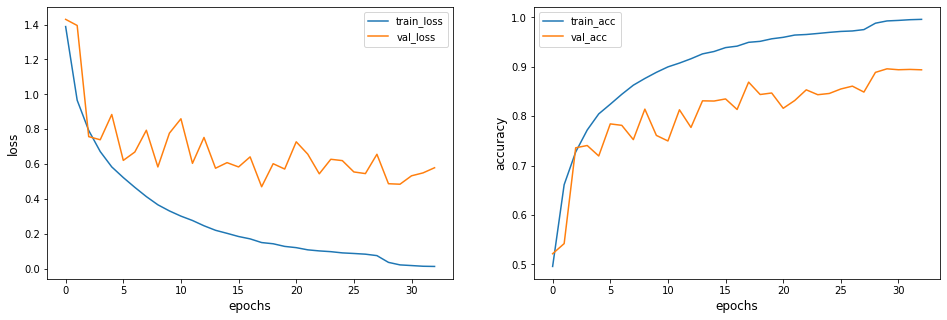

In [ ]:
def show_history(history):
  fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
  axs[0].plot(history.history['loss'], label='train_loss')
  axs[0].plot(history.history['val_loss'], label='val_loss')

  axs[1].plot(history.history['accuracy'], label='train_acc')
  axs[1].plot(history.history['val_accuracy'], label='val_acc')

  axs[0].legend()
  axs[0].set_xlabel('epochs', fontsize=12)
  axs[0].set_ylabel('loss', fontsize=12)

  axs[1].legend()
  axs[1].set_xlabel('epochs', fontsize=12)
  axs[1].set_ylabel('accuracy', fontsize=12)
  plt.show()

show_history(history)

### **6. Evaluate the model**

In [ ]:
model.evaluate(test_generator_flow)

313/313 [==============================] - 2s 7ms/step - loss: 0.5800 - accuracy: 0.8949


[0.5800415873527527, 0.8949000239372253]